# Data Collection, Cleaning and Pre-processing

## Import Libraries

In [17]:
# We import here libraries that we'll use
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox, yeojohnson
from sklearn.preprocessing import PowerTransformer

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Gather Data

In [18]:
df = pd.read_excel(r'./../data/creditcardmarketing.xlsx') # import the excel file using a relative path to the 'data' folder

## Explore and Clean Data

In [19]:
df.head()   # show the first lines of the dataframe that we had imported

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


In [20]:
print("Number of rows: ", df.shape[0])
print('Number of columns: ', df.shape[1])

Number of rows:  18000
Number of columns:  17


> #### **Observations:**
> - column names need to be standardized
> - average balance column needs to be checked against the other quarter balances
> 

In [21]:
# Clean column names, take off blank spaces and #
cols = [col_name.lower().replace(' ', '_') for col_name in df.columns]
df.columns = cols
df.rename(columns={'#_bank_accounts_open': 'bank_accounts_open', '#_credit_cards_held' : 'credit_cards_held', '#_homes_owned' : 'homes_owned'}, inplace=True)

In [22]:
df.info()  # Shows variables informations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_number       18000 non-null  int64  
 1   offer_accepted        18000 non-null  object 
 2   reward                18000 non-null  object 
 3   mailer_type           18000 non-null  object 
 4   income_level          18000 non-null  object 
 5   bank_accounts_open    18000 non-null  int64  
 6   overdraft_protection  18000 non-null  object 
 7   credit_rating         18000 non-null  object 
 8   credit_cards_held     18000 non-null  int64  
 9   homes_owned           18000 non-null  int64  
 10  household_size        18000 non-null  int64  
 11  own_your_home         18000 non-null  object 
 12  average_balance       17976 non-null  float64
 13  q1_balance            17976 non-null  float64
 14  q2_balance            17976 non-null  float64
 15  q3_balance         

> **Note:** dtypes seems to be in order. However, we can see that there are some missing values in the 5 balance columns

In [23]:
# How many null values is present in the data?
nulls = df.isna().sum()
nulls[nulls>0]

average_balance    24
q1_balance         24
q2_balance         24
q3_balance         24
q4_balance         24
dtype: int64

In [24]:
#Percentage of missing values
round(24/df.shape[0],3)

0.001

> **Note:** Since the missing values represent less than 1% of our data, we will opt to drop them. We will, however, save them in a df for safekeeping.

In [25]:
# New dataframe to keep records with null values
df_nans = df[df.average_balance.isna()]
df_nans.head()

,customer_number,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
323,324,No,Points,Postcard,Medium,1,No,High,1,1,4,No,NaN,NaN,NaN,NaN,NaN
3070,3071,Yes,Air Miles,Postcard,Low,3,No,Medium,2,1,4,Yes,NaN,NaN,NaN,NaN,NaN
3108,3109,No,Air Miles,Letter,Low,1,No,High,3,1,4,Yes,NaN,NaN,NaN,NaN,NaN
3789,3790,No,Air Miles,Letter,Medium,2,No,High,3,1,3,No,NaN,NaN,NaN,NaN,NaN
5083,5084,No,Points,Letter,Medium,1,No,High,1,1,3,Yes,NaN,NaN,NaN,NaN,NaN


In [26]:
# Make a copy of the original, cleaned data before dropping the missing values
df_copy = df.copy()

In [27]:
# Drop missing values from the dataframe to be used moving forward since it represents less than 1% of all the records
df = df[~df.average_balance.isna()]
df.shape

(17976, 17)

### Target
 - Our target variable for this project is the offer_accepted column.
 - Below is a closer look at the distribution of the target variable:

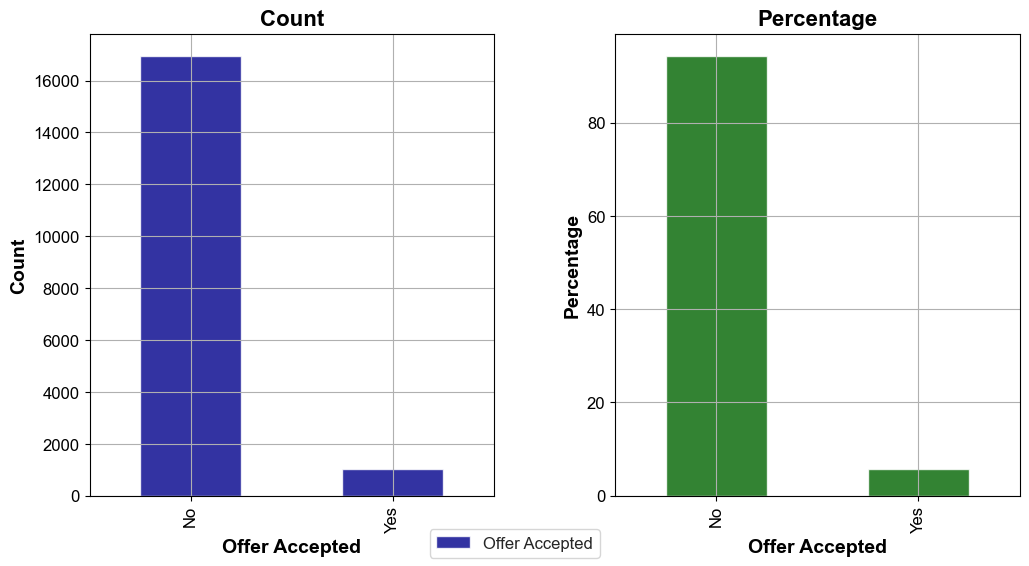

In [28]:
# Compute the count of each category
counts = df['offer_accepted'].value_counts()

# Compute the percentage of each category
percentages = df['offer_accepted'].value_counts(normalize=True) * 100

# Create a grid of two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Set the style using seaborn
sns.set_style("whitegrid")

# Plot the count of each category in the first subplot
counts.plot(kind='bar', ax=ax1, color='darkblue', alpha=0.8)
ax1.set_title('Count', fontsize=16, fontweight='bold')
ax1.set_xlabel('Offer Accepted', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count', fontsize=14, fontweight='bold')
ax1.tick_params(axis='both', labelsize=12)

# Plot the percentage of each category in the second subplot
percentages.plot(kind='bar', ax=ax2, color='darkgreen', alpha=0.8)
ax2.set_title('Percentage', fontsize=16, fontweight='bold')
ax2.set_xlabel('Offer Accepted', fontsize=14, fontweight='bold')
ax2.set_ylabel('Percentage', fontsize=14, fontweight='bold')
ax2.tick_params(axis='both', labelsize=12)

# Add a legend
fig.legend(labels=['Offer Accepted'], loc='lower center', ncol=1, fontsize=12)

# Add some space between the subplots
fig.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()


In [ ]:
target = df.offer_accepted
target = target.map({'No': 0, 'Yes':1})
target.value_counts()

> **Note:** There is a huge imbalance present in the target variable which will definitely impact our models. We will address this imbalance later on.

### Numerical Variables

In [29]:
# Create separate df for numerical variables
numericals = df.select_dtypes(np.number)
numericals.drop('customer_number', axis=1, inplace=True)
numericals.head()

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,1,2,1,4,1160.75,1669.0,877.0,1095.0,1002.0
1,1,2,2,5,147.25,39.0,106.0,78.0,366.0
2,2,2,1,2,276.50,367.0,352.0,145.0,242.0
3,2,1,1,4,1219.00,1578.0,1760.0,1119.0,419.0
4,1,2,1,6,1211.00,2140.0,1357.0,982.0,365.0


In [30]:
numericals.describe().round(2)

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
count,17976.00,17976.0,17976.00,17976.00,17976.00,17976.00,17976.00,17976.00,17976.00
mean,1.26,1.9,1.20,3.50,940.52,910.45,999.39,1042.03,810.19
std,0.47,0.8,0.43,1.11,350.30,620.08,457.40,553.45,559.00
min,1.00,1.0,1.00,1.00,48.25,0.00,0.00,0.00,0.00
25%,1.00,1.0,1.00,3.00,787.50,392.75,663.00,633.00,363.00
50%,1.00,2.0,1.00,3.00,1007.00,772.00,1032.00,945.50,703.00
75%,1.00,2.0,1.00,4.00,1153.25,1521.00,1342.00,1463.00,1212.00
max,3.00,4.0,3.00,9.00,3366.25,3450.00,3421.00,3823.00,4215.00


> **Note:** Looking at some statistics above, we can assume that balance will most likely be skewed. There also seem to be household size that reaches 9 so this column will be looked at in more detail.

In [31]:
numericals.household_size.value_counts()

household_size
3    5705
4    5532
5    2851
2    2809
1     539
6     538
8       1
9       1
Name: count, dtype: int64

In [32]:
numericals[(numericals.household_size == 8) | (numericals.household_size == 9)]

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
38,1,1,2,8,1285.0,206.0,1499.0,1545.0,1890.0
101,1,1,1,9,161.5,44.0,99.0,454.0,49.0


<Axes: >

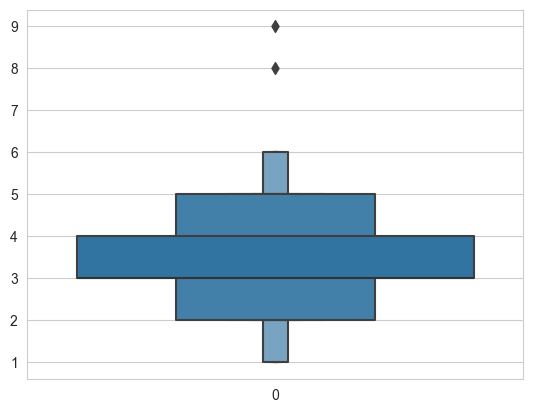

In [33]:
sns.boxenplot(numericals.household_size)

In [34]:
q1 = np.percentile(numericals.household_size,25)
q3 = np.percentile(numericals.household_size,75)
iqr = q3 - q1
upper_limit =  q3 + (1.5 * iqr)
upper_limit.round()

6.0

> **Note:** Seeing as there are only 1 data point each for household sizes 8 and 9, we will be capping both to 6 which is the upper limit.

In [35]:
numericals.household_size = numericals.household_size.apply(lambda x: 6 if x > 6 else x)
numericals.household_size.value_counts().sort_index()

household_size
1     539
2    2809
3    5705
4    5532
5    2851
6     540
Name: count, dtype: int64

In [36]:
# check if average_balance is corresponds to the average of the 4 quarters balance
balance_check = numericals.iloc[:, -4:]
balance_check['avg'] = balance_check.mean(axis=1)
(balance_check.avg == numericals.average_balance).value_counts()

True    17976
Name: count, dtype: int64

> **Note:** The average_balance column IS the average of all 4 quarters balance. Multicollinearity will be checked below.

### Separate Contiuous from Discrete Numerical Variables

In [37]:
# separate df with continuous numerical variables
cont = numericals.iloc[:, -5:]
cont.head()

,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,1160.75,1669.0,877.0,1095.0,1002.0
1,147.25,39.0,106.0,78.0,366.0
2,276.50,367.0,352.0,145.0,242.0
3,1219.00,1578.0,1760.0,1119.0,419.0
4,1211.00,2140.0,1357.0,982.0,365.0


In [38]:
cont.describe().round(2)

,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
count,17976.00,17976.00,17976.00,17976.00,17976.00
mean,940.52,910.45,999.39,1042.03,810.19
std,350.30,620.08,457.40,553.45,559.00
min,48.25,0.00,0.00,0.00,0.00
25%,787.50,392.75,663.00,633.00,363.00
50%,1007.00,772.00,1032.00,945.50,703.00
75%,1153.25,1521.00,1342.00,1463.00,1212.00
max,3366.25,3450.00,3421.00,3823.00,4215.00


In [ ]:
def continous_distribution(df):
    a = math.ceil(df.shape[1]/2)  # number of rows
    b = 2  # number of columns
    c = 1  # initialize plot counter

    fig = plt.figure(figsize = (14,10))
    plt.suptitle("Distribution of Numerical Variables", fontsize = 14, y=1)

    for i in df:
        plt.subplot(a, b, c)
        plt.title('{}'.format(i, a, b, c))
        plt.xlabel(i)
        fig = sns.distplot(df[i])
        fig.axvline(x = np.mean(df[i]), color="red")
        fig.axvline(x = np.median(df[i]), color="green")
        c = c + 1
    
    plt.tight_layout()
    plt.show()

In [ ]:
continous_distribution(cont)

> **Observations:**
>   - average_balance : looks like two normal distributions, one smaller than the other.
>   - q2_balance looks to be closest to the normal distribution.

#### Looking at the Outliers

In [ ]:
def check_outliers(df):
    a = math.ceil(df.shape[1]/2)  # number of rows
    b = 2  # number of columns
    c = 1  # initialize plot counter

    fig = plt.figure(figsize = (14,15))
    plt.suptitle("Plotting Outliers", fontsize = 14, y=1)

    for i in df:
        plt.subplot(a, b, c)
        plt.title('{}'.format(i, a, b, c))
        plt.xlabel(i)
        sns.boxenplot(x = df[i])
        c = c + 1
    
    plt.tight_layout()
    plt.show()

In [ ]:
check_outliers(numericals)

> **Note:** Before dealing with outliers, we will first transform continuous variables.

In [ ]:
# Pearson Correlation for continuous variables
corr_matrix = cont.join(target).corr()

In [ ]:
corr_matrix.head()

In [ ]:
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap using the mask
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', linewidths=.5, ax=ax)

# Add a title and adjust the margins
plt.title('Correlation Matrix Heatmap', fontsize=18)
plt.subplots_adjust(left=0.15, bottom=0.15)

# Show the plot
plt.show()

In [ ]:
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif.round(2)

In [ ]:
calc_vif(numericals)

> **Note:** After checking for the variance inflation factor (VIF) we can see that the average balance and the 4 quarter balances are perfectly correlated with each other. We will still keep all the variables, though, as this would not be a problem for certain models which would be applied later.

In [ ]:
# Discrete Numerical Variables
discrete = numericals.iloc[:, :4].join(target)
discrete

#### Distribution of Discrete Numerical Variables

In [ ]:
a = 2  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize = (13,8))
plt.suptitle("Distribution of Discrete Numerical Variables", fontsize = 14, y=1)
sns.set_palette('colorblind')

for i in discrete.drop('offer_accepted', axis=1):
    plt.subplot(a, b, c)
    plt.title('{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.countplot(data = discrete, x = i)
    c = c + 1

plt.tight_layout()
plt.show()

#### Distribution in Relation With Target

In [ ]:
a = 3  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize = (13,10))
plt.suptitle("Distribution in Relation With Target", fontsize = 14, y=1)
sns.set_palette('colorblind')

for i in discrete:
    plt.subplot(a, b, c)
    plt.title('{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.countplot(data = discrete, x = i, hue=('offer_accepted'))
    c = c + 1

plt.tight_layout()
plt.show()

In [ ]:
# Kendall Correlation
corr_discrete = discrete.corr(method='kendall').round(2)
corr_discrete

In [ ]:
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_discrete, dtype=bool))

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap using the mask
sns.heatmap(corr_discrete, mask=mask, cmap='Spectral', annot=True, fmt='.2f', linewidths=.5, ax=ax)

# Add a title and adjust the margins
plt.title('Discrete Variables Correlation Matrix Heatmap', fontsize=18)
plt.subplots_adjust(left=0.15, bottom=0.15)

# Show the plot
plt.show()

> **Note:** There doesn't seem to be any correlation between the target and the other independent variables.

### Transformations

In [ ]:
def df_transformed(df, function):
    new_df = df.copy()
    for col in new_df:
        new_df[col] = list(map(function, new_df[col]))
    return new_df

# This function 'df_transformed' takes a dataframe 'df' and a function 'function' as inputs, 
# and applies the function to each column of the dataframe. 
# The output is a new dataframe with the transformed values.

In [ ]:
def log_transform(x):
    if np.isfinite(x) and x!=0:
        return np.log(x)
    else:
        return np.NAN 
    
# This function is useful for transforming skewed data or data with outliers, 
# as the logarithmic transformation can help to make the distribution more symmetric and easier to analyze.

In [ ]:
log_cont = df_transformed(cont, log_transform)
log_cont

In [ ]:
continous_distribution(log_cont)

In [ ]:
check_outliers(log_cont)

In [ ]:
def sqrt_transform(x):
    if np.isfinite(x) and x>=0:
        return np.sqrt(x)
    else:
        return np.NAN
    
# This is a function called 'sqrt_transform' that takes a numerical input 'x' and returns the square root of 'x',
# provided that 'x' is finite and greater than or equal to 0. If x is not finite or is less than 0, 
# the function returns 'np.NAN', which stands for "not a number" in numpy.

# This function can also be useful for transforming skewed data or data with outliers, 
# as the square root transformation can help to make the distribution more symmetric and easier to analyze.

In [ ]:
sqrt_cont = df_transformed(cont, sqrt_transform)
sqrt_cont 

In [ ]:
continous_distribution(sqrt_cont)
check_outliers(sqrt_cont)

In [ ]:
from scipy.stats import boxcox, yeojohnson

# Both of these functions can be useful for transforming data that is not normally distributed,
# yeojohnson can be applied to both positive and negative data when boxcox can only deal with positive values.

In [ ]:
boxcox_cont = pd.DataFrame(columns=cont.columns)
bc_lambda = pd.DataFrame(columns=cont.columns)

In [ ]:
def boxcox_transform(col):
    lmbda = []
    if np.all(col > 0):
        # Apply Box-Cox transform for positive values
        transformed_data, lambda_ = boxcox(col)
        lmbda.append(lambda_)
        return transformed_data, lmbda
    else:
        # Apply Yeo-Johnson transform for negative values
        transformed_data, lambda_ = yeojohnson(col)
        lmbda.append(lambda_)
        return transformed_data, lmbda

In [ ]:
for col in cont.columns:
    boxcox_cont[col], bc_lambda[col] = boxcox_transform(cont[col])

In [ ]:
boxcox_cont

In [ ]:
bc_lambda

In [ ]:
continous_distribution(boxcox_cont)
check_outliers(boxcox_cont)

#### Checking Distribution of Transformed Continuous Variables

In [ ]:
def plot_transformations(col):
    # Save original column data
    orig = col
    
    # Transform using Box-Cox
    bc, lmbda = boxcox_transform(col)
    
    # Transform using logarithm
    log = list(map(log_transform, col))
    
    # Transform using square root
    sqrt = list(map(sqrt_transform, col))
    
    # Create figure for plotting
    fig = plt.figure(figsize = (15,8))
    
    # Add title to figure
    plt.suptitle("Data for columns: {}".format(col.name),fontsize = 14, y=1)
    
    # Add subplots for original data and Box-Cox transformed data
    plt.subplot(221)
    fig1 = sns.distplot(orig)
    fig1.axvline(x = orig.mean(), color="red")
    fig1.axvline(x = np.median(orig), color="green")
    plt.title('Original')
    
    plt.subplot(222)
    fig2 = sns.distplot(bc)
    fig2.axvline(x = bc.mean(), color="red")
    fig2.axvline(x = np.median(bc), color="green")
    plt.title('Box-Cox')
    
    # Add subplots for logarithm and square root transformed data
    plt.subplot(223)
    fig3 = sns.distplot(log)
    fig3.axvline(x = np.mean(log), color="red")
    fig3.axvline(x = np.median(log), color="green")
    plt.title('Log Transformed')
    
    plt.subplot(224)
    fig4 = sns.distplot(sqrt)
    fig4.axvline(x = np.mean(sqrt), color="red")
    fig4.axvline(x = np.median(sqrt), color="green")
    plt.title('Square Root')
    
    # Adjust spacing between subplots and show plot
    plt.tight_layout()
    plt.show()


In [ ]:
for col in cont.columns:
    plot_transformations(cont[col])

In [ ]:
# create a StandardScaler object
scaler = StandardScaler()

# fit the scaler to the data
scaled_numericals = scaler.fit_transform(cont)

# create a new dataframe with the scaled data
scaled_df = pd.DataFrame(scaled_numericals, columns=cont.columns)
# plot the histograms
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

for i, col in enumerate(scaled_df.columns):
    axs[i].hist(scaled_df[col], bins=8)
    axs[i].set_title('Histogram of {} (scaled)'.format(col))
    
plt.tight_layout()
plt.show()

### Categorical Variables

In [ ]:
cat_df = df.select_dtypes(include=['object'])

In [ ]:
cat_df.head()

In [ ]:
# separate target variable
y = cat_df.offer_accepted
y.value_counts()

In [ ]:
cat_df.drop('offer_accepted', axis=1, inplace=True)

In [ ]:
#separate ordinal from nominal categoricals
nominal = cat_df[['reward', 'mailer_type', 'overdraft_protection', 'own_your_home']]
nominal.head()

In [ ]:
# Use pandas get_dummies to create binary indicators for each category
encoded_df = pd.get_dummies(nominal).astype(int)
encoded_df

In [ ]:
#ordinal variables
ordinal = cat_df[['income_level', 'credit_rating']]
ordinal.head()


In [ ]:
order = {'Low' : 0, 'Medium': 1, 'High' : 2}
ordinal.income_level = ordinal.income_level.map(order)
ordinal.credit_rating = ordinal.credit_rating.map(order)

In [ ]:
ordinal.nunique()

In [ ]:
categoricals = pd.concat([ordinal, encoded_df], axis=1)
categoricals.head()

In [ ]:
X = numericals.join(categoricals)
#X.drop('customer_number', axis=1, inplace=True)

In [ ]:
X.head()

In [ ]:
y.info()

In [ ]:
X